# Salary Prediction of NBA basketball players

- Fares Feki
- Juhyun Kim
- Zongmin Li
- Nhat-Minh Dao
- Tahn-Nam Nguyen
- Nada Amini


Our project was inspired by these articles *Estimating NBA players salary share according to their performance on court*, and the article *Does Racial Discrimination Exist Within the NBA? An analysis Based on Salary-per-Contribution*, both articles can be found in the repository. The aim of our project is to present a notebook that predicts the salary of NBA players given a season.

Actually, at first we focused our attention on the season **2015-2016** to analyse our approach and our methodology and then we added other seasons for comparison purposes and also to perform a new way of cross validating our models.

Our raw data consisted of three seperate databases, that again can be found in the repository:

- *players cv.xlsx* : this dataset contains personal information about players such as the height, the origin, the race...
- *players stat.xlsx* : this dataset contains the statistics concercning the performance of each player.
- *players salary.xlsx* : this dataset contains the names of the players, the teams they play in and their respective salaries.

We cleaned these three datasets separately and then merged them into one big dataset that we'll preprocess and run through our different models. The dataset contains several basketball statistics of the players and a column of the salary of each player. We'll start by giving the explanation of each feature of the dataset: 

- **Player**: The name of the player
- **Season**: The season of NBA.
- **Tm**: Team of the player
- **Age**: Age of the player
- **G**: Games. It the number of games a player has played in
- **GS**: Game Started. it means the number of games in which a player has started in the game.
- **MP**: Minutes Played
- **PER**: Player efficiency rating
- **3APr**: 3-Point Attempt rate
- **FTr**: Free Throw Attempt rate
- **ORB%**: Offensive Rebound Percentage
- **DRB%**: Defensive Rebound Percentage
- **TRB%**: Total Rebound Percentage
- **AST%**: Assist Percentage
- **STL%**: Steal Percentage
- **BLK%**: Block Percentage
- **TOV%**: Turnover Percentage
- **USG%**: Usage Percentage
- **ORtg**: Offensive Rating
- **DRtg**: Defensive Rating
- **OWS**: Offensive Win share
- **DWS**: Defensive Win share
- **WS/48**: Win shares per 48 minutes
- **OBPM**: Offensive Box Plus/Minus
- **DBPM**: Defensive Box Plus/Minus
- **BPM**: Box Plus/Minus
- **VORP**: Value over Replacement Player
- **Place_of_birth**: is the place of birth of the player (it can be a statet of the USA and that's why we added the following new column)
- **state_or_country**: it indicates whether the place of birth is a state of the USA or a country of the world 
- **Race**: Race of the player: Black, White, Black and White or other
- **seniority**: it's the duration in terms of years of how long the player has been playing basket basketball up to the current season.
- **Pos**: Position in which the player plays on the basketball court
- **Ht**: Height of the player
- **Wt**: The weight of the player
- **College**: College to which the player went
- **Salary**: Our target variable that we want to predict: the salary of the player

Another idea that popped into our heads for when we will add the other seasons is to take into consideration the factor of inflation in the salaries of the players to make our predictions more accurate.

In [1]:
# Importing the necesarry packages and librairies
import numpy as np
import pandas as pd
import pylab as pl
import copy as cp
import string
import re

import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
pd.set_option('display.max_columns', None)

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the datasets
data_path = "data/"
player_stat = pd.read_excel(data_path + "players stat.xlsx")
player_cv = pd.read_excel(data_path + "players cv.xlsx")
player_salary = pd.read_excel(data_path + "players salary.xlsx")

In [3]:
# Restricting the dataset to the season 2015-2016
player_stat_15_16 = player_stat[player_stat['Season'] == '2015-16']
player_salary_15_16 = player_salary[player_salary['SEASON'] == '2015-2016']
player_cv_15_16 = player_cv[(player_cv['From']<=2016) & (player_cv['To']>=2015)]

In [4]:
print("Player stat:", player_stat_15_16.shape)
print("Player salary:", player_salary_15_16.shape)
print("Player CV:", player_cv_15_16.shape)

Player stat: (476, 29)
Player salary: (416, 5)
Player CV: (566, 10)


Merging the datasets player_CV and player_stat was relatively easy in comparison with merging player_stat and player_salary because the names in both datasets were written in the same format. We used an inner join because in order to only take the intersection of players and avoid NaN values.

In [5]:
# Merging the datasets player cv and player stat
merge_stat_cv = pd.merge(player_stat_15_16, player_cv_15_16, left_on='Player', right_on='Player', how='inner')

This function below came as a consequence of a manual filtering of the names in the datasets to cover all the exceptions.

In [6]:
# This function helps reformat the names in the player_stat database to the same format of player_salary
def preprocess_name(name):
    if ',' in name:
        ind = name.find(',')
        name = name[:ind]
    ### We remove the Jr.
    if "Jr." in name:
        name = name.replace("Jr.", "")
    if "Jr" in name:
        name = name.replace("Jr.", "")
    if "III" in name:
        name = name.replace("III", "")
    while '.' in name:
        ind = name.find('.')
        name = name.replace('.','')
    name = name.lower()
    
    return name

In [7]:
# To be safe, we apply the same name preprocessing function to the two databases 
player_salary_15_16['Player'] = player_salary_15_16['NAME'].apply(lambda s: preprocess_name(s))
merge_stat_cv['Player'] = merge_stat_cv['Player'].apply(lambda s: preprocess_name(s))

# Merging the three datasets
merge_15_16 = pd.merge(merge_stat_cv, player_salary_15_16, left_on='Player', right_on='Player', how='inner')
merge_15_16.shape

(377, 43)

Initially, all the three databases were almost of size 500 rows. But after doing the intersection and preprocessing we can observe that the size of the database decreased considerably, because some players existed in a database and not in another.

## Final dataset for the season: 2015-2016

In [8]:
merge_15_16.head()

,Player,Season,Age,Tm,Lg,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,SEASON,RK,NAME,TEAM,SALARY
0,thanasis antetokounmpo,2015-16,23.0,NYK,NBA,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,2015-2016,416,"Thanasis Antetokounmpo, SF",New York Knicks,30888
1,stephen curry,2015-16,27.0,GSW,NBA,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,2015-2016,55,"Stephen Curry, PG",Golden State Warriors,11370786
2,kevin durant,2015-16,27.0,OKC,NBA,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,2015-2016,7,"Kevin Durant, SF",Oklahoma City Thunder,20158622
3,boban marjanovic,2015-16,27.0,SAS,NBA,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,2016,2016,C,7-3,290,"August 15, 1988",NaN,2015-2016,315,"Boban Marjanovic, C",San Antonio Spurs,1200000
4,russell westbrook,2015-16,27.0,OKC,NBA,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,2009,2016,G,6-3,200,"November 12, 1988","University of California, Los Angeles",2015-2016,16,"Russell Westbrook, PG",Oklahoma City Thunder,16744218


## Adding other seasons

In [9]:
merge_14_15 = pd.read_csv(data_path + "merge_14_15.csv")
merge_13_14 = pd.read_csv(data_path + "merge_13_14.csv")

In order to be more accurate, we integrated the inflation factor in the salary column for the different years. We take as reference the year 2016. According to this website: https://stats.areppim.com/calc/calc_usdlrxdeflator.php, 1.00 US Dollars of 2014 are worth 1.02 US Dollars of 2016 and 1.00 US Dollars of 2015 are worth 1.01 US Dollars of 2016.

In [10]:
merge_15_16['SALARY'] = merge_15_16['SALARY'] * 1.0
merge_14_15['SALARY'] = merge_14_15['SALARY'] * 1.01
merge_13_14['SALARY'] = merge_13_14['SALARY'] * 1.02

In [11]:
final_df = pd.concat([merge_15_16, merge_14_15, merge_13_14]).reset_index(drop=True)
print(final_df.shape)

(1163, 43)


In [12]:
final_df.head()

,Player,Season,Age,Tm,Lg,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,SEASON,RK,NAME,TEAM,SALARY
0,thanasis antetokounmpo,2015-16,23.0,NYK,NBA,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,2015-2016,416,"Thanasis Antetokounmpo, SF",New York Knicks,30888.0
1,stephen curry,2015-16,27.0,GSW,NBA,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,2015-2016,55,"Stephen Curry, PG",Golden State Warriors,11370786.0
2,kevin durant,2015-16,27.0,OKC,NBA,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,2015-2016,7,"Kevin Durant, SF",Oklahoma City Thunder,20158622.0
3,boban marjanovic,2015-16,27.0,SAS,NBA,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,2016,2016,C,7-3,290,"August 15, 1988",NaN,2015-2016,315,"Boban Marjanovic, C",San Antonio Spurs,1200000.0
4,russell westbrook,2015-16,27.0,OKC,NBA,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,2009,2016,G,6-3,200,"November 12, 1988","University of California, Los Angeles",2015-2016,16,"Russell Westbrook, PG",Oklahoma City Thunder,16744218.0


## Preprocessing

The columns **NAME** and **SEASON** and **TEAM** are repeated twice so we can remove the duplicated columns. Also, we can remove the column of the league because they all play for the NBA for these seasons. Finally, we drop the column of the player's names because it's a categorical column that takes a different value for each row.

In [13]:
# We made a deepcopy of the dataset to keep the original untouched since we will modify this one in preprocessing
M = cp.deepcopy(final_df)
to_drop = ['Lg', 'NAME', 'Player', 'SEASON', 'TEAM']
M.drop(to_drop, axis=1, inplace=True)
M.head()

,Season,Age,Tm,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,From,To,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,23.0,NYK,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,2016,2016,F,6-7,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,27.0,GSW,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,2010,2016,G,6-3,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,27.0,OKC,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,2008,2016,F,6-9,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,27.0,SAS,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,2016,2016,C,7-3,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,27.0,OKC,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,2009,2016,G,6-3,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


We observe that our dataset contains a lot of important categorical features like the basketball team of the players and their colleges... So it's important to find the most efficient way to encode them. During the week of the data camp, we saw many encoding techniques and that this step is critical in our preprocessing since it can influence significantly our model performance.

We decided to use the Count Ordinal Encoder for all categorical variables because:

- We could've used the Ordinal encoding, but we didn't because it can introduce bias and give for example a race superiority over another for the race column. 


- We didn't use Count Encoding because it can be a source of collisions. 


- We didn't use One hot encoding because during the week of the data camp we saw that it's mostly used with linear algorithms. Moreover, it can lead to sparse representations if we have many categories like in **Place_of_Birth** and **College**.


- Finally,  we chose the Count Ordinal Encoding because it works for both linear and non linear algorithms. 


In [14]:
from helpers import CountOrdinalEncoder
## We use the code from the Datacamp week for the CountOrdinalEncoder
coe = CountOrdinalEncoder()
new_c = coe.fit_transform(pd.DataFrame(M['Tm']))
new_c = new_c.reshape(len(new_c),)
M.drop('Tm', axis=1, inplace=True)
M.insert(1, 'Tm', new_c)

The initial height values are feet mixed with inches and we want a more homogenous value, so we convert it to centimeters

In [15]:
# Converting height from feet to centimeters
from helpers import convert_height
new_c = np.array(M['Ht'].apply(convert_height))
new_c = new_c.reshape(len(new_c),)
M.drop('Ht', axis=1, inplace=True)
M.insert(32, 'Ht', new_c)

The initial dataframe contained the first year in which the player started playing (*From*) up to the year of the season (*To*). In order to better use this information, we came up with the idea of taking the difference. We can interpret this new column as the seniority of the player. 

In [16]:
# The "From" and "To" columns are redundant, we can just convert them to a column seniority
duration = M['To'] - M['From']
M.insert(29, 'seniority', duration)
M.drop('To', axis=1, inplace=True)
M.drop('From', axis=1, inplace=True)

M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,Black,0,F,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,Black and White,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,Black,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,White,0,C,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,Black,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


In [17]:
# Encoding the race into a numerical value
pd.Categorical(M['Race']).categories

Index(['Black', 'Black and White', 'Others', 'White'], dtype='object')

In [18]:
new_c = coe.fit_transform(pd.DataFrame(M['Race']))
new_c = new_c.reshape(len(new_c),)
M.drop('Race', axis=1, inplace=True)
M.insert(28, 'Race', new_c)
M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,Greece,3.0,0,F,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,Ohio,1.0,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,District of Columbia,3.0,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,Russia,2.0,0,C,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,California,3.0,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


Now we will work on the Place of Birth of the players

In [19]:
print(np.sort(M['Place_of_Birth'].unique()))
print(len(M['Place_of_Birth'].unique()))

['Alabama' 'Alaska' 'Argentina' 'Arizona' 'Arkansas' 'Arkansas '
 'Australia' 'Belgium' 'Bosnia and Herzegovina' 'Brazil' 'California'
 'California ' 'Cameroon' 'Canada' 'Cape Verde' 'Colorado' 'Congo'
 'Croatia' 'Czech Republic' 'Democratic Republic of the Congo'
 'District of Columbia' 'Dominican Republic' 'Dominican Repulic' 'England'
 'Florida' 'Florida ' 'France' 'French Guiana' 'Georgia' 'Georgia '
 'Germany' 'Greece' 'Haiti' 'Idaho' 'Illinois' 'Illinois ' 'Indiana'
 'Indiana ' 'Iowa' 'Israel' 'Italy' 'Kansas' 'Kentucky' 'Kentucky '
 'Latvia' 'Lithuania' 'Louisiana' 'Macedonia' 'Maryland' 'Maryland '
 'Massachusetts' 'Mexico' 'Michigan' 'Michigan ' 'Minnesota' 'Minnesota '
 'Mississippi' 'Mississippi ' 'Missouri' 'Missouri ' 'Montenegro' 'Nevada'
 'New Hampshire' 'New Jersey' 'New Mexico' 'New York' 'New Zealand'
 'New zealand' 'Nigeria' 'North Carolina' 'North Carolina ' 'North Dakota'
 'Ohio' 'Ohio ' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Pennsylvania '
 'Poland' 'Puerto Rico' 'Re

We notice that some states and countries appeared twice because of lower/uppercase differences and extra spaces at the end.
For example, we have `'Missouri'` and  `'Missouri '`, `'Serbia'` and `'serbia'` etc. So, we decided to add some preprocessing to put it all in the same format.

In [20]:
def correct_names(s):
    s = s.lower().strip() #lowercase and remove the extra space at the end
    return s

M['Place_of_Birth'] = M['Place_of_Birth'].apply(lambda s: correct_names(s))

There's also a misspell in the name of **Wisconsin** that need to be corrected. Also, **Russia** and **Russian Federation** mean the same country so we need to correct it. 

In [21]:
# Changing Federation of Russia to Russia
indices = np.where(M['Place_of_Birth'] == "russian federation")[0]
M['Place_of_Birth'][indices] = "russia"

# Correcting Wisconsin
indices = np.where(M['Place_of_Birth'] == "wisvonsin")[0]
M['Place_of_Birth'][indices] = "wisconsin"

print(np.sort(M['Place_of_Birth'].unique()))
print(len(M['Place_of_Birth'].unique()))

['alabama' 'alaska' 'argentina' 'arizona' 'arkansas' 'australia' 'belgium'
 'bosnia and herzegovina' 'brazil' 'california' 'cameroon' 'canada'
 'cape verde' 'colorado' 'congo' 'croatia' 'czech republic'
 'democratic republic of the congo' 'district of columbia'
 'dominican republic' 'dominican repulic' 'england' 'florida' 'france'
 'french guiana' 'georgia' 'germany' 'greece' 'haiti' 'idaho' 'illinois'
 'indiana' 'iowa' 'israel' 'italy' 'kansas' 'kentucky' 'latvia'
 'lithuania' 'louisiana' 'macedonia' 'maryland' 'massachusetts' 'mexico'
 'michigan' 'minnesota' 'mississippi' 'missouri' 'montenegro' 'nevada'
 'new hampshire' 'new jersey' 'new mexico' 'new york' 'new zealand'
 'nigeria' 'north carolina' 'north dakota' 'ohio' 'oklahoma' 'oregon'
 'pennsylvania' 'poland' 'puerto rico' 'republic of the congo'
 'rhode island' 'russia' 'senegal' 'serbia' 'slovenia' 'south africa'
 'south carolina' 'south dakota' 'south sudan' 'spain' 'sweden'
 'switzerland' 'tennessee' 'texas' 'turkey' 'u.s. v

We noticed that we have a mix between states of the USA and countries of the world as places of birth of the players. So, we will add another column to specify if it's a state of the USA or an actual country. This column will be categorical and it will take 1 if the place of birth is a state of the USA and 0 if it's a country of the world.

In [22]:
states = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia',
          'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
          'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey',
          'New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island',
          'South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia',
          'Wisconsin','Wyoming']
states = [state.lower() for state in states]

In [23]:
M.insert(28,'state_or_country',M['Place_of_Birth'].isin(states) * 1)

# We encode the place of birth by count ordinal encoding
new_c = coe.fit_transform(pd.DataFrame(M['Place_of_Birth']))
new_c = new_c.reshape(len(new_c),)
M.drop('Place_of_Birth', axis=1, inplace=True)
M.insert(27, 'Place_of_Birth', new_c)
M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,F,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,G,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,F,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,C,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,G,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


In [24]:
print('All possible positions are:', list(pd.Categorical(M['Pos']).categories))

# Encoding positions
new_c = coe.fit_transform(pd.DataFrame(M['Pos']))
new_c = new_c.reshape(len(new_c),)
M.drop('Pos', axis=1, inplace=True)
M.insert(31, 'Pos', new_c)
M.head()

All possible positions are: ['C', 'C-F', 'F', 'F-C', 'F-G', 'G', 'G-F']


,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,Birth Date,College,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,5.0,200.66,205,"July 17, 1992",NaN,416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,6.0,190.50,185,"March 14, 1988",Davidson College,55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,5.0,205.74,240,"September 29, 1988",University of Texas at Austin,7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,4.0,220.98,290,"August 15, 1988",NaN,315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,6.0,190.50,200,"November 12, 1988","University of California, Los Angeles",16,16744218.0


In [25]:
print('All possible colleges are:', list(pd.Categorical(M['College']).categories))
print('\n\nNumber of colleges: ', len(list(pd.Categorical(M['College']).categories)))

All possible colleges are: ['Arizona State University', 'Baylor University', 'Belmont University', 'Blinn College', 'Boston College', 'Bowling Green State University', 'Brigham Young University', 'Bucknell University', 'Butler University', 'California State University, Fresno', 'California State University, Long Beach', 'Central Michigan University', 'Clemson University', 'Cleveland State University', 'Colorado State University', 'Creighton University', 'Davidson College', 'DePaul University', 'Duke University', 'Duquesne University', 'Eastern Washington University', 'Florida State University', 'Georgetown University', 'Georgia Institute of Technology', 'Georgia State University', 'Gonzaga University', 'Harvard University', 'Indiana University', 'Indiana University-Purdue University Indianapolis', 'Iowa State University', 'Kansas State University', 'La Salle University', 'Lehigh University', 'Louisiana State University', 'Louisiana Tech University', 'Marquette University', 'Marshall Un

Now, we will encode the college column using the COE as before. In fact, we believe this feature can be important since colleges with good basketball teams tend to offer scholarships to high school students that have good performance in this sport. Consequently, a player with a high salary is more likely to have studied in a college with a good basketball team. This assumption is to be confirmed by plots shown later in this notebook.

In [26]:
# Treating NAN values of this column
# We will just replace all this players of whom we don't have info about the college with "Missing"      
M['College'][np.where(M['College'].isna() == True)[0]] = "Missing"
new_c = coe.fit_transform(pd.DataFrame(M['College']))
new_c = new_c.reshape(len(new_c),)
M.drop('College', axis=1, inplace=True)
M.insert(34, 'College', new_c)

M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,College,Birth Date,RK,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,5.0,200.66,205,125.0,"July 17, 1992",416,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,6.0,190.50,185,48.0,"March 14, 1988",55,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,5.0,205.74,240,117.0,"September 29, 1988",7,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,4.0,220.98,290,125.0,"August 15, 1988",315,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,6.0,190.50,200,120.0,"November 12, 1988",16,16744218.0


We will drop **Date of Birth**, since it's redundant because we already have the age of each player stored in a column.
We also drop the column **RK**. In fact, this column represents the ranking of the players based on their salary, so we cannot use it as a feature.

In [27]:
M.drop('Birth Date', axis=1, inplace=True)
M.drop('RK', axis=1, inplace=True)

M.head()

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,College,SALARY
0,2015-16,11.0,23.0,2,0.0,6.0,32.9,0.250,0.000,0.0,17.9,9.1,0.0,0.0,0.0,0.0,30.2,140.0,110.0,0.0,0.0,0.0,0.291,6.3,-10.5,-4.1,0.0,47.0,0,3.0,0,5.0,200.66,205,125.0,30888.0
1,2015-16,14.0,27.0,79,79.0,2700.0,31.5,0.554,0.250,2.9,13.6,8.6,33.7,3.0,0.4,12.9,32.6,125.0,103.0,13.8,4.1,17.9,0.318,12.4,0.1,12.5,9.8,85.0,1,1.0,6,6.0,190.50,185,48.0,11370786.0
2,2015-16,21.0,27.0,72,72.0,2578.0,28.2,0.348,0.361,2.0,21.8,12.4,24.2,1.3,2.5,13.5,30.6,122.0,104.0,11.0,3.5,14.5,0.270,7.0,0.9,7.9,6.4,62.0,0,3.0,8,5.0,205.74,240,117.0,20158622.0
3,2015-16,28.0,27.0,54,4.0,508.0,27.7,0.000,0.655,16.9,26.2,21.7,6.6,1.2,3.5,11.5,22.8,130.0,96.0,2.3,1.2,3.4,0.325,2.7,0.9,3.6,0.7,59.0,0,2.0,0,4.0,220.98,290,125.0,1200000.0
4,2015-16,21.0,27.0,80,80.0,2750.0,27.6,0.236,0.397,6.1,18.1,12.4,49.6,2.9,0.6,16.8,31.6,115.0,103.0,10.0,4.0,14.0,0.245,7.6,2.4,10.0,8.3,89.0,1,3.0,7,6.0,190.50,200,120.0,16744218.0


In [28]:
M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1163 entries, 0 to 1162
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            1163 non-null   object 
 1   Tm                1163 non-null   float64
 2   Age               1163 non-null   float64
 3   G                 1163 non-null   int64  
 4   GS                1163 non-null   float64
 5   MP                1163 non-null   float64
 6   PER               1163 non-null   float64
 7   3PAr              1161 non-null   float64
 8   FTr               1161 non-null   float64
 9   ORB%              1163 non-null   float64
 10  DRB%              1163 non-null   float64
 11  TRB%              1163 non-null   float64
 12  AST%              1163 non-null   float64
 13  STL%              1163 non-null   float64
 14  BLK%              1163 non-null   float64
 15  TOV%              1161 non-null   float64
 16  USG%              1163 non-null   float64


We notice that we have NaN values in our dataframe. Let's investigate this.

In [29]:
M[M.isna().any(axis=1)]

,Season,Tm,Age,G,GS,MP,PER,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Place_of_Birth,state_or_country,Race,seniority,Pos,Ht,Wt,College,SALARY
285,2015-16,19.0,21.0,3,0.0,6.0,10.8,NaN,NaN,0.0,18.5,9.2,0.0,8.2,0.0,NaN,0.0,NaN,95.0,0.0,0.0,0.0,0.116,-5.3,5.8,0.5,0.0,68.0,1,2.0,0,5.0,205.74,230,76.0,1646400.0
745,2014-15,23.0,32.0,2,0.0,19.0,4.3,NaN,NaN,0.0,6.2,3.0,14.0,0.0,0.0,NaN,0.0,214.0,119.0,0.0,0.0,0.0,0.009,-5.6,-2.1,-7.7,0.0,76.0,0,3.0,9,5.0,208.28,249,94.0,1515000.0


We see that all the missing values are located only in two rows. Morever, since the missing values are key performance features for the two players, replacing these values with the mean (or median) might induce predictions errors. Instead, we decided to simply drop these lines.

In [30]:
ind = np.where(M['3PAr'].isna())[0]
M.drop(ind, axis=0, inplace=True)
M.reset_index(drop=True, inplace=True)

The preprocessing step is now over, the next step will be the data analysis which will help us select the features for salary prediction.

## Data Analysis

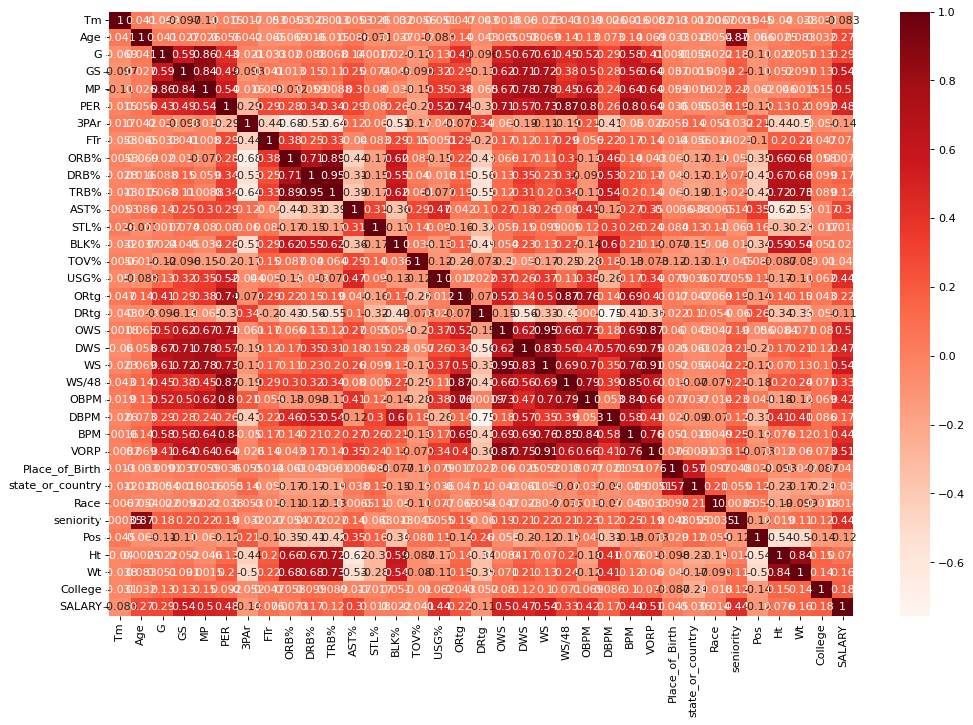

In [31]:
M[M.columns].corr()

plt.figure(figsize=(15, 10), dpi=80)
sns.heatmap(M[M.columns].corr(), annot=True, cmap = 'Reds')
plt.show()

The high correlations suggest that many of the columns contain redundant information, i.e. information from one column is contained in other columns. We can only use a subset of the columns for training and predicting. However, we chose not drop any column since a regularized model can do feature selection on its own.

## First experiment

At first, we wanted to see what features are the most discriminative via a Lasso regression. To do so, we decided at first to limit ourselves to one season. Afterwards, we will code a more sophisticated way  of splitting which will be more adapted to our dataframe.

In [32]:
# Splitting into tagert and learning data
M_15_16 = M[M['Season']=='2015-16']
Y = cp.deepcopy(M_15_16['SALARY'])
col = list(set((M_15_16.columns))- set(['SALARY', 'Season']))
X = cp.deepcopy(M_15_16[col])

Y = np.array(Y).reshape(-1,1)

# Splitting into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

scaler = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)

X_test_scaled = scaler.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

## Model 1: Lasso Regression

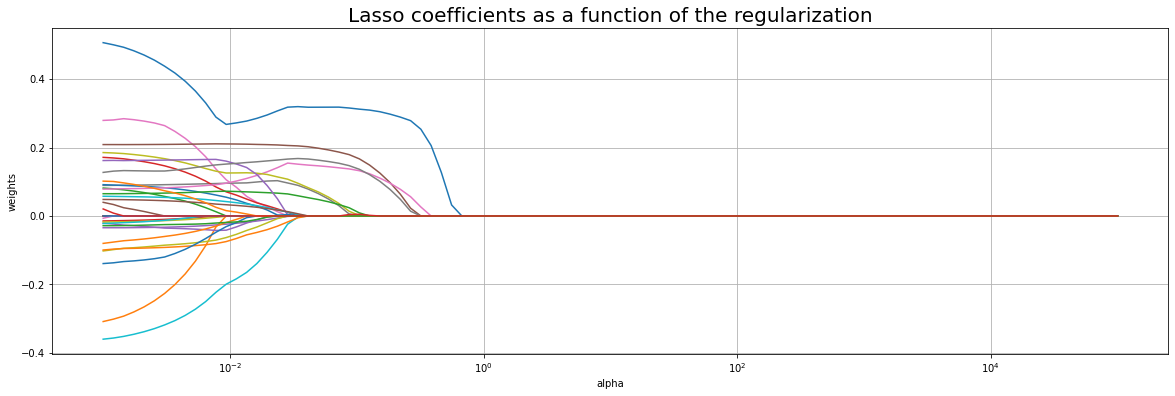

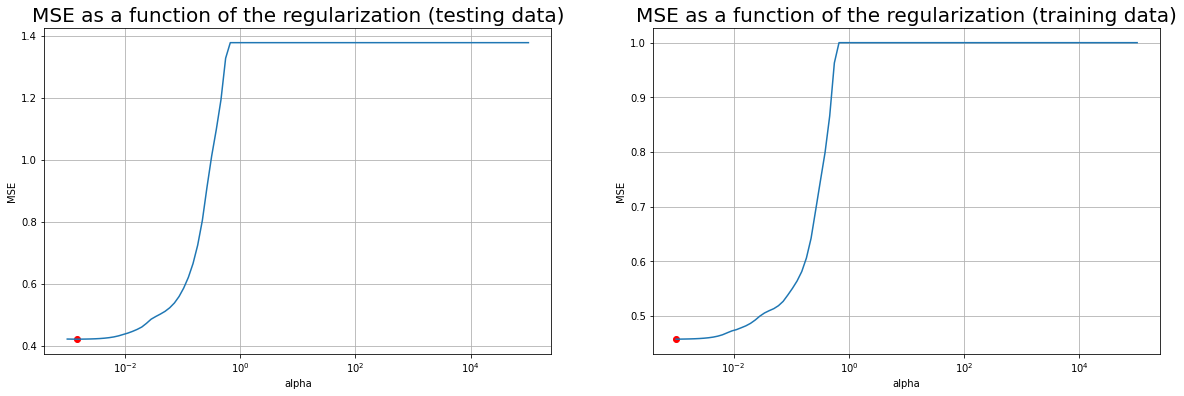

In [33]:
n_lasso = 100
weights_lasso, MSE_lasso, MSE_lasso_app = list(), list(), list()
alphas_lasso = np.logspace(-3, 5, n_lasso)
for a in alphas_lasso:
    lasso = Lasso(alpha = a)
    lasso.fit(X_train_scaled, y_train_scaled)
    weights_lasso.append(lasso.coef_)
    y = lasso.predict(X_test_scaled)
    y_app = lasso.predict(X_train_scaled)
    MSE_lasso.append(mean_squared_error(y, y_test_scaled))
    MSE_lasso_app.append(mean_squared_error(y_app, y_train_scaled))
weights_lasso = np.array(weights_lasso)

pl.figure(11, figsize=(20, 6))
ax = pl.gca()
for i in range(weights_lasso.shape[1]):
    ax.plot(alphas_lasso, weights_lasso[:,i])
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('weights')
pl.title('Lasso coefficients as a function of the regularization', fontsize = 20)
pl.grid()
pl.axis('tight')

pl.figure(12, figsize=(20, 6))
pl.subplot(1,2,1)
ax = pl.gca()
ax.plot(alphas_lasso, MSE_lasso)
ax.scatter(alphas_lasso[np.argmin(MSE_lasso)], np.amin(MSE_lasso), c = 'red')
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('MSE')
pl.title('MSE as a function of the regularization (testing data)', fontsize = 20)
pl.grid()
pl.axis('tight')
pl.subplot(1,2,2)
ax = pl.gca()
ax.plot(alphas_lasso, MSE_lasso_app)
ax.scatter(alphas_lasso[np.argmin(MSE_lasso_app)], np.amin(MSE_lasso_app), c = 'red')
ax.set_xscale('log')
pl.xlabel('alpha')
pl.ylabel('MSE')
pl.title('MSE as a function of the regularization (training data)', fontsize = 20)
pl.grid()
pl.axis('tight')
pl.show()

- The top plot represents the regularization path. This illustrates the fact that Lasso performs feature selection.


- The two bottom plots show the optimal $\lambda$ values for on test and train sets

In [34]:
alpha_optim_lasso = alphas_lasso[np.argmin(MSE_lasso)]
model_lasso_optim = Lasso(alpha = alpha_optim_lasso)
model_lasso_optim.fit(X_train_scaled, y_train_scaled)
print("\nThe value of alpha that gives the smallest MSE score is: {}".format(np.round(alpha_optim_lasso,5)))


The value of alpha that gives the smallest MSE score is: 0.00145


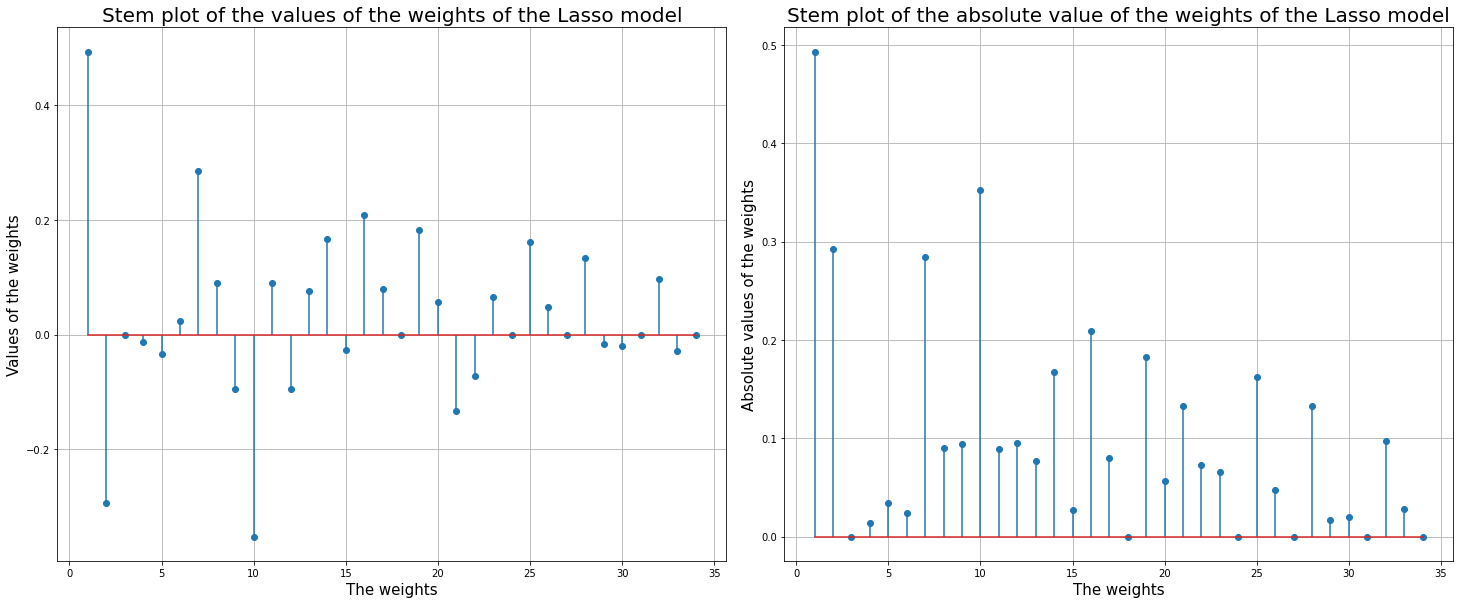

In [35]:
# Looking at the selection made by Lasso and use it to do variable selection and apply it to a non linear model
pl.figure(14, figsize = (20,8))
x = np.array([i+1 for i in range(model_lasso_optim.coef_.shape[0])])
pl.subplot(1,2,1)
pl.tight_layout(h_pad = 5, w_pad = 5)
pl.stem(x, model_lasso_optim.coef_, use_line_collection = True)
pl.title("Stem plot of the values of the weights of the Lasso model",fontsize=20)
pl.xlabel("The weights",fontsize=15)
pl.ylabel("Values of the weights",fontsize=15)
pl.grid()
pl.subplot(1,2,2)
pl.stem(x, np.abs(model_lasso_optim.coef_), use_line_collection = True)
pl.title("Stem plot of the absolute value of the weights of the Lasso model",fontsize=20)
pl.xlabel("The weights",fontsize=15)
pl.ylabel("Absolute values of the weights",fontsize=15)
pl.grid()

In [36]:
print('The corresponding features of the stem plot:\n', col)

The corresponding features of the stem plot:
 ['WS', 'VORP', 'TRB%', 'state_or_country', 'Tm', 'DBPM', 'BPM', 'Wt', 'BLK%', 'G', 'Ht', 'STL%', 'ORB%', 'DWS', '3PAr', 'seniority', 'GS', 'Age', 'AST%', 'Race', 'ORtg', 'DRB%', 'College', 'OWS', 'MP', 'Place_of_Birth', 'WS/48', 'USG%', 'Pos', 'TOV%', 'OBPM', 'DRtg', 'FTr', 'PER']


Now, we evaluate the performance of our first model on the test set. To do so, we chose the MSE, which is the standard metric for regression. Moreover, to relatively quantify the error made by the model, we used a scale-free metric such as the $R^2$ score.

In [37]:
y_predicted = model_lasso_optim.predict(X_test_scaled)
print("The MSE score is:", mean_squared_error(y_test_scaled, y_predicted))
print("The R2 score is:", r2_score(y_test_scaled, y_predicted))

The MSE score is: 0.42190522179800133
The R2 score is: 0.681657996929115


## Model 2: XGBoost

We also wanted to use a non linear model because they are generally more performant than linear models like Lasso regression.

In [38]:
model_rd = XGBRegressor()
model_rd.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

y_pred = model_rd.predict(X_test_scaled)
print("The MSE score is:", mean_squared_error(y_test_scaled, y_pred))
print("The R2 score is:", r2_score(y_test_scaled, y_pred))

In our case, the Lasso regression is more accurate than the XGBRegressor with default parameters.

## Cross validation

We decided to define our own cross validation class. Instead of splitting our data randomly as we often do in regular dataframes, we took into consideration the season information. Each time we keep aside one season for the test and train the model on the remaining seasons. 

The aim of this type of cross validation is to test the robustness of our model for when we change seasons.

In [39]:
from sklearn.model_selection import BaseCrossValidator

class SeasonSplit(BaseCrossValidator):

    def __init__(self, season_col='Season'):  
        self.season_col = season_col

    def get_n_splits(self, X, y=None, groups=None):
        return len(X.reset_index()[self.season_col].unique())

    def split(self, X, y, groups=None):
        n_splits = self.get_n_splits(X, y, groups)
        X = X.reset_index()
        season_names = X[self.season_col].unique()
        for i in range(n_splits):
            test_season = season_names[i]
            
            idx_test = list(X[X[self.season_col]==test_season].index)
            
            idx_train = list(set(X.index) - set(idx_test))
            yield (
                idx_train, idx_test
            )


We now test our splitter that performs cross validation on seasons from 2013-14 to 2015-16 and as a regressor we use XGBoost.

In [40]:
features = list(set((M.columns))- set(['SALARY']))
X, y = M[features], M['SALARY']

In [41]:
X = X.reset_index()

In [42]:
X = X.set_index(['index', 'Season'])

In [43]:
from sklearn.model_selection import cross_val_score

In [44]:
model_rd = XGBRegressor(random_state=0)
season_cv = SeasonSplit()
print(cross_val_score(model_rd, X, y, cv=season_cv, scoring='r2'))

[0.48059771 0.59990244 0.4876059 ]


In [45]:
train_idx, test_idx = season_cv.split(X,y)

<generator object SeasonSplit.split at 0x0000012A9CDDDC10>